## Data Analytics

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from pymongo import MongoClient
import json, re
from re import sub
from decimal import Decimal
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask.delayed import delayed

### Dask Client

In [2]:
client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:44653 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.63 GB


### Database Connection

In [3]:
DB_USER = 'anutibara'
DB_PASS = 'anutibara'
DB_HOST = 'scraping-cluster-7dtgt.gcp.mongodb.net'
DB_NAME = 'scraping_db'

try:
    client = MongoClient(f'mongodb+srv://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}')
    print("Database connected successfully")
except Exception as e:
    print("Error to connect to database: ", e)
db = client.get_database(DB_NAME)
properties = db.properties

Database connected successfully


### Database Queries

In [4]:
properties.count_documents({})

22574

### Convert Mongo Collection to DataFrame

#### New Properties

In [5]:
new_properties_json = list(properties.find({ 'use': 'Nuevo' }))

In [308]:
df_new_properties = json_normalize(new_properties_json, record_path='offersType', 
                                meta=['_id', 
                                    'urlProperty',
                                    'scrapingDate', 
                                    'scrapingHour', 
                                    'modifyDate',
                                    'modifyHour', 
                                    'code', 
                                    'status', 
                                    'type', 
                                    'use', 
                                    'nameProject', 
                                    'description',
                                     'country',
                                     'department',
                                     'city',
                                     'sector',
                                     'neighborhood',
                                     'address',
                                     'latitude',
                                     'longitude',
                                     'idOwnerProperty',
                                     'nameOwnerProperty',
                                     'contractType',
                                     'financing',
                                     'schedule',
                                     'price',
                                     'squareMeters',
                                     'rooms',
                                     'bathrooms',
                                     'garages',
                                     'privateArea',
                                     'constructionArea',
                                     'squareMetersPrice',
                                     'stratum',
                                     'condition',
                                     'antiquity',
                                     'floor',
                                     'interiorFloors',
                                     'weather',
                                     'includesAdministration',
                                     'admonPrice'])
ddf_new_properties = dd.from_pandas(df_new_properties, npartitions=1)

In [309]:
ddf_new_properties = ddf_new_properties.loc[:,~ddf_new_properties.columns.duplicated(keep='first')]

In [310]:
ddf_new_properties = ddf_new_properties.dropna()

#### Old Properties

In [33]:
old_properties_json = list(properties.find({ 'use': 'Usado' }))

In [311]:
df_old_properties = pd.DataFrame(old_properties_json, 
                                    columns=['_id', 
                                    'urlProperty', 
                                    'scrapingDate', 
                                    'scrapingHour', 
                                    'modifyDate',
                                    'modifyHour', 
                                    'code', 
                                    'status', 
                                    'type', 
                                    'use', 
                                    'nameProject', 
                                    'description',
                                    'country',
                                     'department',
                                     'city',
                                     'sector',
                                     'neighborhood',
                                     'address',
                                     'latitude',
                                     'longitude',
                                     'idOwnerProperty',
                                     'nameOwnerProperty',
                                     'contractType',
                                     'financing',
                                     'schedule',
                                     'price',
                                     'squareMeters',
                                     'rooms',
                                     'bathrooms',
                                     'garages',
                                     'privateArea',
                                     'constructionArea',
                                     'squareMetersPrice',
                                     'stratum',
                                     'condition',
                                     'antiquity',
                                     'floor',
                                     'interiorFloors',
                                     'weather',
                                     'includesAdministration',
                                     'admonPrice'])
ddf_old_properties = dd.from_pandas(df_old_properties, npartitions=1)

In [312]:
ddf_old_properties = ddf_old_properties.loc[:,~ddf_old_properties.columns.duplicated(keep='first')]

In [313]:
ddf_old_properties = ddf_old_properties.dropna()

### Rename DataFrame Columns

#### New Properties

In [314]:
ddf_new_properties = ddf_new_properties.rename(columns={
                        "_id": "id_mongoose", 
                        "urlProperty":"id_property",
                        "scrapingDate": "scraping_date",
                        "scrapingHour": "scraping_hour",
                        "modifyDate": "modify_date",
                        "modifyHour": "modify_hour",
                        "status": "active",
                        "use": "new_property",
                        "nameProject": "name_project",
                        "offersType": "offers_type",
                        "idOwnerProperty": "id_owner_property",
                        "nameOwnerProperty": "name_owner_property",
                        "contractType": "contract_type_owner_property",
                        "financing": "financing_owner_property",
                        "schedule": "schedule_owner_property",
                        "squareMetersPrice": "square_meters_price",
                        "interiorFloors": "interior_floors",
                        "includesAdministration": "includes_administration",
                        "admonPrice": "admon_price",
                        "interiorFeatures": "interior_features",
                        "exteriorFeatures": "exterior_features",
                        "sectorFeatures": "sector_features",
                        "bathrooms": "general_bathrooms",
                        "rooms": "general_rooms",
                        "price": "range_prices",
                        "squareMeters": "range_square_meters",
                        "constructionArea": "range_construction_area",
                        "offerType": "offer_type",
                        "privateArea": "range_private_area",
                        "areaOfferType": "area",
                        "bathroomsOfferType": "bathrooms",
                        "priceOfferType": "price",
                        "privateAreaOfferType": "private_area",
                        "roomsOfferType": "rooms"
})

#### Old Properties

In [315]:
ddf_old_properties = ddf_old_properties.rename(columns={
                        "_id": "id_mongoose", 
                        "urlProperty":"id_property",
                        "scrapingDate": "scraping_date",
                        "scrapingHour": "scraping_hour",
                        "modifyDate": "modify_date",
                        "modifyHour": "modify_hour",
                        "status": "active",
                        "use": "new_property",
                        "nameProject": "name_project",
                        "offersType": "offers_type",
                        "idOwnerProperty": "id_owner_property",
                        "nameOwnerProperty": "name_owner_property",
                        "contractType": "contract_type_owner_property",
                        "financing": "financing_owner_property",
                        "schedule": "schedule_owner_property",
                        "squareMeters": "square_meters",
                        "privateArea": "private_area",
                        "constructionArea": "construction_area",
                        "squareMetersPrice": "square_meters_price",
                        "interiorFloors": "interior_floors",
                        "includesAdministration": "includes_administration",
                        "admonPrice": "admon_price",
                        "offerType": "offer_type",
                        "areaOfferType": "area",
                        "bathroomsOfferType": "bathrooms",
                        "priceOfferType": "price",
                        "privateAreaOfferType": "private_area",
                        "roomsOfferType": "rooms"
})

### Data Cleaning

#### New Properties

In [316]:
ddf_new_properties['id_mongoose'] = ddf_new_properties['id_mongoose'].astype(str)
ddf_new_properties['code'] = ddf_new_properties['code'].astype(int)
ddf_new_properties['active'] = ddf_new_properties['active'].apply(lambda status: True if (status == 'Active') else False, meta=('active', 'bool'))
ddf_new_properties['new_property'] = ddf_new_properties['new_property'].apply(lambda status: True if (status == 'Nuevo') else False, meta=('new_property', 'bool'))
ddf_new_properties['includes_administration'] = ddf_new_properties['includes_administration'].apply(lambda status: True if (status == 'Nuevo') else False, meta=('includes_administration', 'bool'))
ddf_new_properties['garages'] = ddf_new_properties['garages'].replace('', value = 0, regex = True).astype(int)
ddf_new_properties['stratum'] = ddf_new_properties['stratum'].replace('', value = 0, regex = True).astype(int)
ddf_new_properties['floor'] = ddf_new_properties['floor'].astype(int)
ddf_new_properties['area'] = ddf_new_properties['area'].astype(float)
ddf_new_properties['private_area'] = ddf_new_properties['private_area'].replace('', value = 0, regex = True)
ddf_new_properties['private_area'] = ddf_new_properties['private_area'].astype(float)
ddf_new_properties['rooms'] = ddf_new_properties['rooms'].astype(int)
ddf_new_properties['bathrooms'] = ddf_new_properties['bathrooms'].astype(int)
ddf_new_properties['price'] = ddf_new_properties['price'].apply(lambda price: Decimal(sub(r'[^\d,]', '', price)), meta=('price', 'int'))
ddf_new_properties['price'] = ddf_new_properties['price'].astype(int)

#### Old Properties

In [317]:
ddf_old_properties['id_mongoose'] = ddf_old_properties['id_mongoose'].astype(str)
ddf_old_properties['code'] = ddf_old_properties['code'].astype(int)
ddf_old_properties['active'] = ddf_old_properties['active'].apply(lambda status: True if (status == 'Active') else False, meta=('active', 'bool'))
ddf_old_properties['new_property'] = ddf_old_properties['new_property'].apply(lambda status: True if (status == 'Nuevo') else False, meta=('new_property', 'bool'))
ddf_old_properties['includes_administration'] = ddf_old_properties['includes_administration'].apply(lambda status: True if (status == 'Nuevo') else False, meta=('includes_administration', 'bool'))
ddf_old_properties['garages'] = ddf_old_properties['garages'].replace('', value = 0, regex = True)
ddf_old_properties['garages'] = ddf_old_properties['garages'].replace('Más de 10', value = 0, regex = True)
ddf_old_properties['garages'] = ddf_old_properties['garages'].astype(int)
ddf_old_properties['stratum'] = ddf_old_properties['stratum'].replace('', value = 0, regex = True)
ddf_old_properties['stratum'] = ddf_old_properties['stratum'].replace('Campestre', value = 0, regex = True)
ddf_old_properties['stratum'] = ddf_old_properties['stratum'].astype(int)
ddf_old_properties['price'] = ddf_old_properties['price'].apply(lambda price: Decimal(sub(r'[^\d,]', '', price)), meta=('price', 'int'))
ddf_old_properties['price'] = ddf_old_properties['price'].astype(int)
ddf_old_properties['square_meters'] = ddf_old_properties['square_meters'].str[0:-3]
ddf_old_properties['square_meters'] = ddf_old_properties['square_meters'].replace('', value = '0', regex = True)
ddf_old_properties['square_meters'] = ddf_old_properties['square_meters'].apply(lambda meters: Decimal(sub(r'[^\d,]', '', meters)), meta=('square_meters', 'float'))
ddf_old_properties['square_meters'] = ddf_old_properties['square_meters'].astype(float)
ddf_old_properties['private_area'] = ddf_old_properties['private_area'].str[0:-3]
ddf_old_properties['private_area'] = ddf_old_properties['private_area'].replace('', value = '0', regex = True)
ddf_old_properties['private_area'] = ddf_old_properties['private_area'].apply(lambda area: Decimal(sub(r'[^\d,]', '', area)), meta=('private_area', 'float'))
ddf_old_properties['private_area'] = ddf_old_properties['private_area'].astype(float)
ddf_old_properties['construction_area'] = ddf_old_properties['construction_area'].str[0:-3]
ddf_old_properties['construction_area'] = ddf_old_properties['construction_area'].replace('', value = '0', regex = True)
ddf_old_properties['construction_area'] = ddf_old_properties['construction_area'].apply(lambda area: Decimal(sub(r'[^\d,]', '', area)), meta=('construction_area', 'float'))
ddf_old_properties['construction_area'] = ddf_old_properties['construction_area'].astype(float)
ddf_old_properties['floor'] = ddf_old_properties['floor'].astype(int)

### Data Analytics

#### New Properties

In [362]:
import pyarrow
from dask.diagnostics import ProgressBar
from dask.array import stats as dask_stats
import seaborn
import matplotlib.pyplot as plt

In [363]:
dd.to_parquet(ddf_new_properties, 'new-properties', engine='pyarrow')

In [364]:
with open(r'./new-properties/part.0.parquet', 'rb') as f:
    data_new_properties = pd.read_parquet(f, engine='pyarrow')

In [365]:
with ProgressBar():
    condition = (data_new_properties['stratum'] == 4)
    stratum_by_price_new = data_new_properties[condition]['price'].value_counts().sort_values()

In [366]:
df_new = stratum_by_price_new.to_frame()

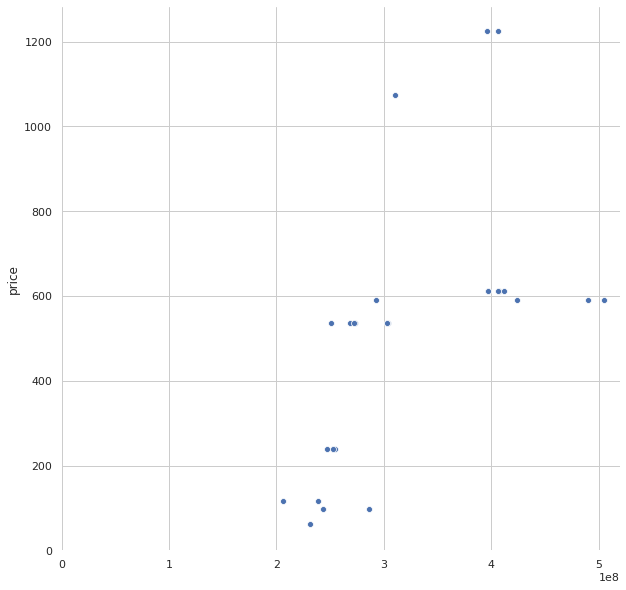

In [367]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
seaborn.despine(f, left=True, bottom=True)

with ProgressBar():
    seaborn.scatterplot(x=df_new.index, y="price",
                data=df_new, ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

#### Old Properties

In [368]:
dd.to_parquet(ddf_old_properties, 'old-properties', engine='pyarrow')

In [369]:
with open(r'./old-properties/part.0.parquet', 'rb') as f:
    data_old_properties = pd.read_parquet(f, engine='pyarrow')

In [370]:
with ProgressBar():
    condition = (data_old_properties['stratum'] == 4) & (data_old_properties['type'] == 'Arriendo')
    stratum_by_price_old = data_old_properties[condition]['price'].value_counts().sort_values()

In [372]:
df_old = stratum_by_price_old.to_frame()

In [ ]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
seaborn.despine(f, left=True, bottom=True)

with ProgressBar():
    seaborn.scatterplot(x=df_new.index, y="price",
                data=df_new, ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)